### Load all

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# My codes
import decoder_PC2d
import model_viz6_functions as modelviz_utils
# from model_viz6_functions import plot_samples 
############################################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
# import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

[16:17:04] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=376943;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=698167;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=477055;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=205184;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=204701;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=318666;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/sruthi/Documents/thesis/distributional-sr/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, se

### ENV and MODEL path and CONFIGs here

In [2]:
ENVIRONMENT = "Ratinabox-v0-pc-random" 
model_path = "logdir-rat_50pc_random_dFalse"  # not distributional

In [3]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [4]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (12000, 50)
NUM_STATE_DIM_CELLS: 50


In [5]:
# env = envs.make(ENVIRONMENT) 
# dir(env)

### Input xs - create dataset of place cell activations over the whole env

In [6]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

(100, 50)


### Decode position from PC activity

/home/sruthi/Documents/thesis/distributional-sr/decoder_PC2d.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.0613305  0.04887155]
 [0.06288972 0.06809048]
 [0.04785715 0.03777817]
 ...
 [0.02465939 0.02217075]
 [0.03679996 0.02369886]
 [0.04441818 0.02699223]]


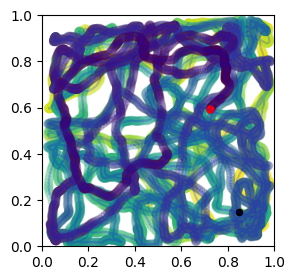

In [7]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=50)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

### Model stuff - restoring checkpoint

In [8]:
state, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 11, num_state_dims = 50)
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

[16:17:35] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=931329;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=304602;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=381186;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=350364;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=133844;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=591610;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[16:17:41] INFO     Restoring item from                                                         ]8;id=732972;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=95654;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random_dFal                    
                    se/500000.                                                                                     

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


[16:17:42] INFO     Finished restoring checkpoint from                                          ]8;id=266840;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=96972;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random_dFal                    
                    se/500000.                                                                                     

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 55, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 50), 'kernel': (10, 32, 50)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 50
)>


### compute DSM samples

atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

source pos:  [0.35 0.95]
debugging generated zs :  -2.5862386 3.8087635
decoded source:  [0.3784433 0.9136371]


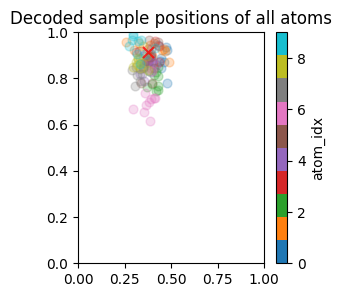

In [9]:
source_idx = 3
source=source_states_env[source_idx]
print('source pos: ',env_coords_small[source_idx])
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='GP')

# atom_idx = 2
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')
# # plot of positions_pred
# modelviz_utils.plot_samples(PCs, dataset.observation, samples,source, make_dataset=False,atom=atom_idx,method='dropoutNet')

original source:  [0.05 0.75]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.1345865, 0.12522608) ; Atom 3
decoded source:  [0.07603547 0.7148149 ]


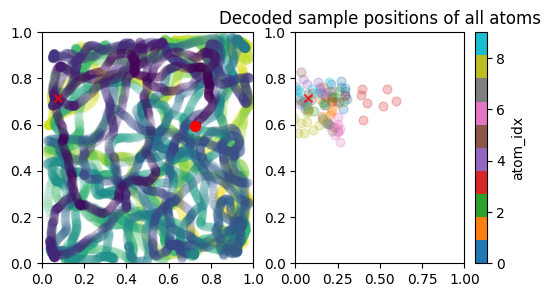

In [10]:
source_idx = 20
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(0)
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

original source:  [0.05 0.75]
Using provided zs


decoded source:  [0.07603547 0.7148149 ]


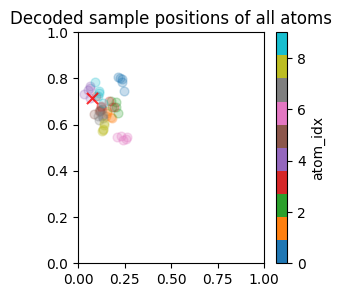

In [11]:
num_samples= 5
source_idx = 20
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(0)
z0 = np.ones((num_samples, config.num_outer, config.latent_dims)) #*10  # latent_rng not used if zs provided
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

In [12]:
# showing SDs of decoded samples - 1 from each atom 
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[:,3,:], method='dropoutNet',return_std=True)
print(f'SD of decoded samples with dropoutNet:{positions_std}')

# showing SDs of decoded samples - from 4th atom
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[3,:,:], method='dropoutNet',return_std=True)
print(f'SD of decoded samples with dropoutNet:{positions_std}')

SD of decoded samples with dropoutNet:[[0.07497105 0.07099265]
 [0.07721373 0.04696304]
 [0.05335211 0.02681152]
 [0.06404892 0.0550533 ]
 [0.05937333 0.06067469]
 [0.06878226 0.06456766]
 [0.07995412 0.03511266]
 [0.04147561 0.05547461]
 [0.05838567 0.03417692]
 [0.0737194  0.05099839]]
SD of decoded samples with dropoutNet:[[0.07232679 0.08312173]
 [0.06011451 0.07451528]
 [0.08176897 0.0518923 ]
 [0.06114914 0.06187518]
 [0.0463392  0.0945221 ]]


##### Decoder uncertainty

In [13]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = plt.get_cmap('tab10')

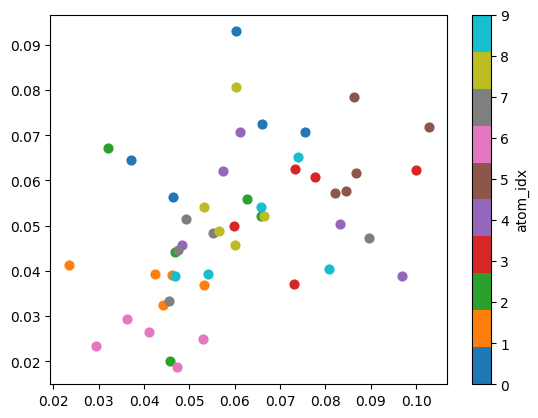

In [14]:
atom_idx_values = np.arange(10) #[3,4,8]
norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))

for atom_idx in atom_idx_values:
    method='dropoutNet'
    positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method=method,return_std=True)
    plt.scatter(positions_std[:, 0], positions_std[:, 1], color=cmap(norm(atom_idx)), s=40)
    # range_column1 = (np.min(positions_std[:, 0]), np.max(positions_std[:, 0]))
    # range_column2 = (np.min(positions_std[:, 1]), np.max(positions_std[:, 1]))
    maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
    if maxc1 > 0.1 and maxc2 > 0.1:
        print(f'Max SD of decoded samples of atom {atom_idx} with {method}: {maxc1, maxc2}')

# Create a ScalarMappable object and use it to add a colorbar to the plot
sm = ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca(), label='atom_idx')
plt.show()

### Experimenting with changed basis vectors
- just make 1st PC value as 0 ?

original source:  [0.05 0.75]
Using provided zs
decoded source:  [0.07603547 0.7148149 ]


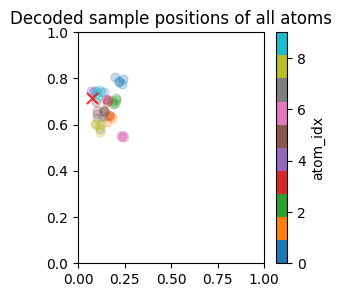

PCs : source[:2]=0
Using provided zs
decoded source:  [0.076251   0.71520543]


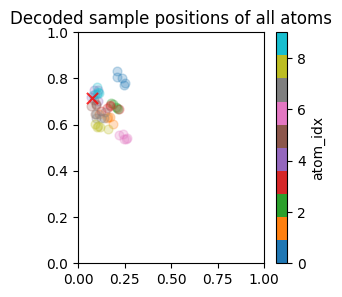

PCs source[-10:]=0
Using provided zs
decoded source:  [0.07228839 0.6540033 ]


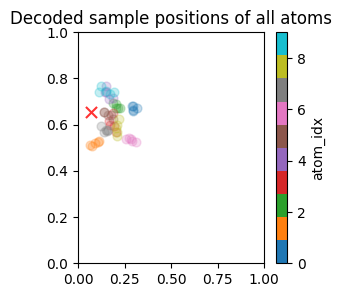

In [15]:
num_samples= 5
source_idx = 20
source=source_states_env[source_idx].copy()
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(0)
z0 = np.ones((num_samples, config.num_outer, config.latent_dims)) #*10  # latent_rng not used if zs provided

source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)


# Changing basis vector - PC which is source 
source[:2]=0
print('PCs : source[:2]=0')
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')

source=source_states_env[source_idx].copy()
# Changing basis vector - PC which is source 
source[-10:]=0
print('PCs source[-10:]=0')
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')


## Plot intermediate activations of ith Atom


- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

In [16]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 0  # ith atom
num_outer = config.num_outer 
atom_params = modelviz_utils. extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (55, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (50,), 'kernel': (32, 50)}}


### Dense 3 activations  - PC ratemaps 

Dense 3 activations correspond to 50 PCs outputs per source; should look like place cell ratemaps 

#### different Zs - latents

In [17]:
# - here,  test different latents
layers = ['Dense_3',]

activations_layer_randomz = []
for i in range(3):
    zs = jax.random.normal(jax.random.PRNGKey(i), (config.latent_dims,))
    # zs = np.ones((config.latent_dims)) *np.exp(i) # latent_rng not used if zs provided
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

# Plotting all the neurons
# for i in range(len(activations_layer_randomz)):
#     neuron_idx = np.arange(activations_layer_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)
#     # neuron_idx=0
#     # modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)


zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


zs [ 0.95730704 -0.9699289  -0.1102333   0.3661903   0.1729483 ]
zs [-0.15508525  1.5718881  -0.37886548  0.17252125 -0.60508585]


NEURON:  40


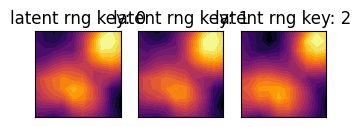

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

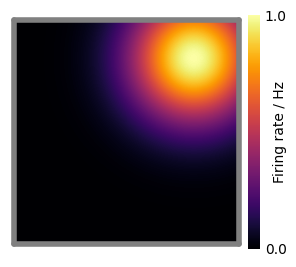

In [18]:
neuron_idx=40
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_randomz, 'latent rng key', neuron_idx, xpos, ypos)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
## to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_randomz[0],neuron_idx,layers,xpos,ypos)


##### Changing basis vector - PC

In [19]:
# Changing basis vector - PC which is source 
changed_source_states = source_states_env.copy()  # shape (100,50) when env discretized into 100 
changed_source_states[:,-10:]=0  # Zeroing out last 10 PCs

activations_layer_randomz = []
for i in range(3):
    zs = jax.random.normal(jax.random.PRNGKey(i), (config.latent_dims,))
    # zs = np.ones((config.latent_dims)) *np.exp(i) # latent_rng not used if zs provided
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, changed_source_states, zs, layers)
    activations_layer_randomz.append(activations_layer)


zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


zs [ 0.95730704 -0.9699289  -0.1102333   0.3661903   0.1729483 ]
zs [-0.15508525  1.5718881  -0.37886548  0.17252125 -0.60508585]


NEURON:  40


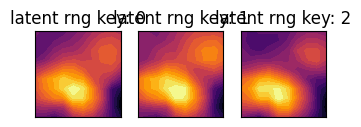

In [20]:
neuron_idx=40
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_randomz, 'latent rng key', neuron_idx, xpos, ypos)

#### All ATOMS - Plot rate map of neuron_idx

In [21]:
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_utils.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer)


Layer: ['Dense_3'] - Neuron: 40


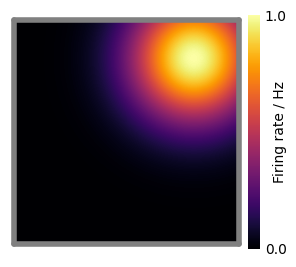

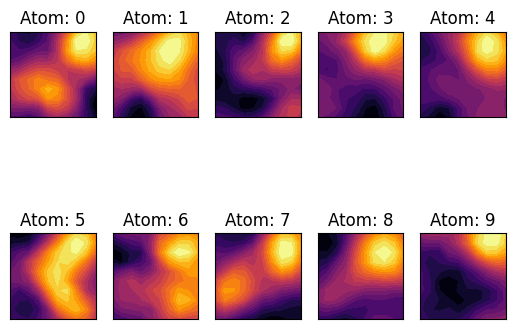

In [22]:
#TODO - select neuron_idx
neuron_idx=40 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_all_atoms[0],neuron_idx,layers,xpos,ypos)

Layer: ['Dense_3'] - Neuron: 40


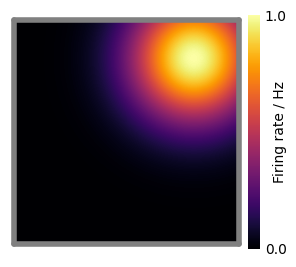

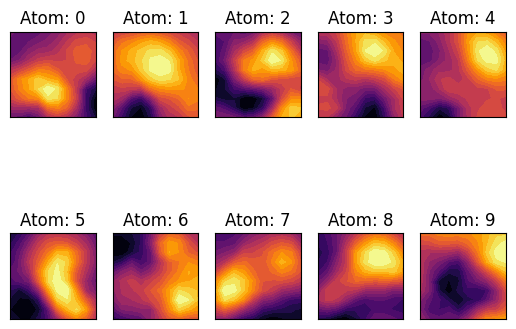

In [29]:
# Changing basis vector - PC which is source 
changed_source_states = source_states_env.copy()  # shape (100,50) when env discretized into 100 
changed_source_states[:,-10:]=0  # Zeroing out last 10 PCs

# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_utils.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, changed_source_states,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

#TODO - select neuron_idx
neuron_idx=40 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)


### Different atom

(100, 50)
neuron:  40


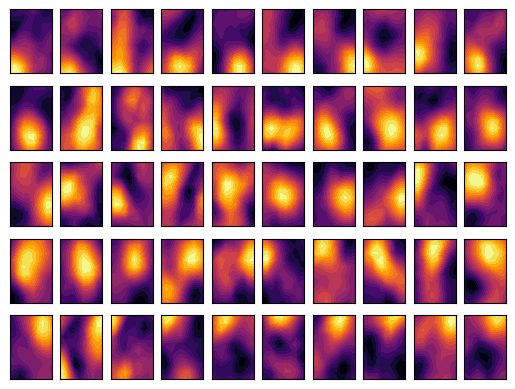

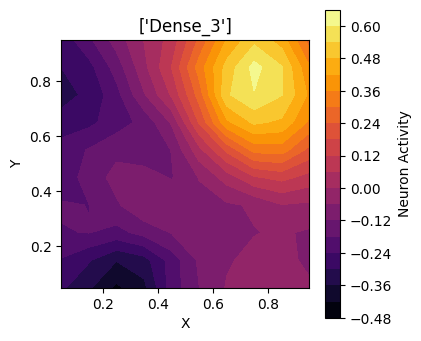

In [23]:
atom_idx = 4  # ith atom
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

atom_params = modelviz_utils.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
print(activations_layer.shape)
neuron_idx = np.arange(activations_layer.shape[-1])
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)
neuron_idx=40
print('neuron: ',neuron_idx)
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)

### Other Dense layers

#### Dense 0,1,2

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


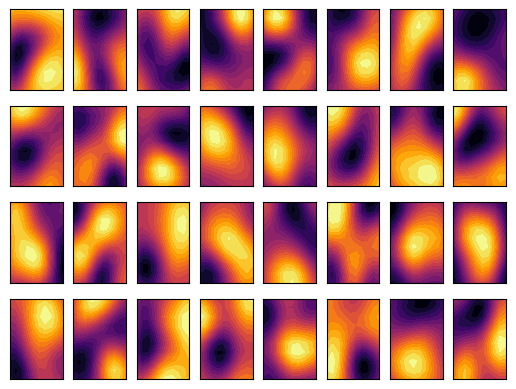

In [24]:
layers = ['Dense_0',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_neuron = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_neuron.shape[1]))
modelviz_utils.plot_neuron_activations(activations_neuron,neuron_idx,layers,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


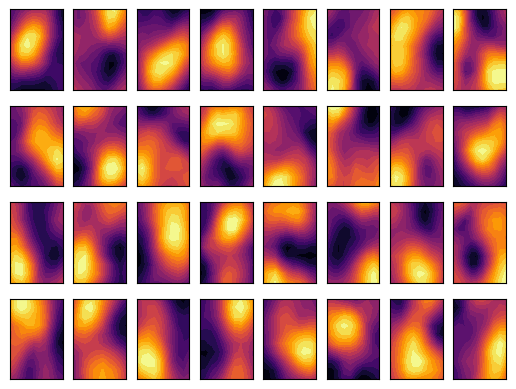

In [25]:
layers = ['Dense_1',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_neuron = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_neuron.shape[1]))
modelviz_utils.plot_neuron_activations(activations_neuron,neuron_idx,layers,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


(100, 32)


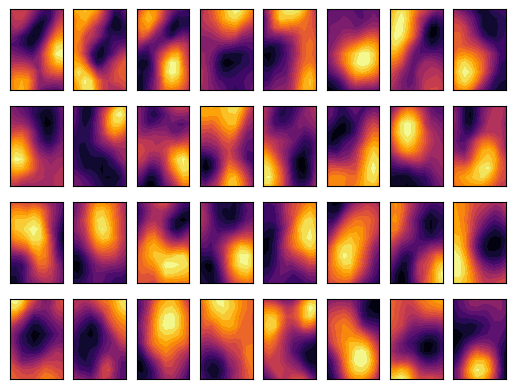

In [26]:
layers = ['Dense_2',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

    print(activations_layer.shape)
    neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)


In [27]:
### All intermediates

# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (num_latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )

# joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent0.pkl')

## Later

- decoding from hidden neuron to start and end state, 
- tsne/ umap
- entropy

Model will generate different successor states from the same source state (effect of different latents?, try giving all 5 same?). \
Different source states may generate same successor states (same x,y positions) 

xs[:,:,-3:] #same - context - source state , rest noise latent dims  \
 xs_atom #shape (8)

In [28]:
# from model_viz6_functions import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(state.generator, atom_params, source_states_env, layers,num_samples,num_latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)